In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def read_consumption(
    file_netconnect: str = "data\AggregatedConsumptionData NetConnect.csv",
    file_gaspool: str = "data\Aggregated Consumption Date Market Area GASPOOL.csv",
    file_the: str = "data\AggregatedConsumptionData Trading Hub.csv",
) -> tuple([pd.Series, pd.Series, pd.Series]):
    """Reads historic natural gas consumption in MWh and returns them as a tuple of pandas series."""

    # Read NetConnect Germany CSV file
    ncg_consumption = pd.read_csv(file_netconnect, sep=";", index_col="DayOfUse")

    ncg_consumption.index = pd.to_datetime(ncg_consumption.index, format="%d.%m.%Y")

    # Convert kWh to MWh and aggregate different measurement types
    ncg_consumption = ncg_consumption.select_dtypes("number") / 1000
    ncg_consumption_aggregated = ncg_consumption.sum(axis="columns")

    # Read GASPOOL CSV file
    gaspool_consumption = pd.read_csv(file_gaspool, sep=";", index_col="Datum")

    gaspool_consumption.index = pd.to_datetime(
        gaspool_consumption.index, format="%d.%m.%Y"
    )
    gaspool_consumption_aggregated = gaspool_consumption.sum(axis="columns")

    # Read Trading Hub Europe CSV file
    the_consumption = pd.read_csv(file_the, sep=";", thousands=",", index_col="Gasday")

    the_consumption.index = pd.to_datetime(the_consumption.index, format="%d/%m/%Y")

    # Convert kWh to MWh and aggregate different measurement types
    the_consumption = the_consumption.select_dtypes("number") / 1000
    the_consumption_aggregated = the_consumption.sum(axis="columns")

    return tuple(
        [
            ncg_consumption_aggregated.sort_index(),
            gaspool_consumption_aggregated.sort_index(),
            the_consumption_aggregated.sort_index(),
        ]
    )

In [5]:
def read_temperatures(file: str = "data/open-meteo-52.55N13.41E38m.csv") -> pd.Series:
    """Reads ERA5 temperature data from a CSV file and returns a pandas Series with temperature in Celsius."""
    
    # Load the data
    data = pd.read_csv(file, sep=",", skiprows=2, header=0)

    # Convert sunshine duration from seconds to hours
    data["sunshine_duration (s)"] = data["sunshine_duration (s)"] / 3600
    data = data.rename(columns={"sunshine_duration (s)": "sunshine_duration (h)"})
    
    # Rename and format the date column
    data = data.rename(columns={"time": "Date"})
    data["Date"] = pd.to_datetime(data["Date"])
    
    # Set the date column as the index
    data.set_index("Date", inplace=True)
    
    return data

In [23]:
ncg_consumption, gaspool_consumption, the_consumption = read_consumption()
consumption_data = pd.concat([ncg_consumption.add(gaspool_consumption, fill_value=0), the_consumption])

# avoir le premier et le dernier index de la série
start_date = consumption_data.index[0].strftime("%Y-%m-%d")
end_date = consumption_data.index[-1].strftime("%Y-%m-%d")

temperature = read_temperatures()
# afficher les colonnes du dataframe
print(temperature.columns)
temp_2m_max = temperature["temperature_2m_mean (°C)"]
temp_2m_max = temp_2m_max[start_date:end_date] # avoir les dates des températures maximales à partir de start_date jusqu'à end_date

Index(['temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'temperature_2m_mean (°C)', 'sunshine_duration (h)',
       'wind_speed_10m_max (km/h)'],
      dtype='object')


In [20]:
# compter les na dans les series
print(consumption_data.isna().sum())
print(temp_2m_max.isna().sum())

0
0


In [24]:
consumption_data.corr(temp_2m_max)

np.float64(-0.753669898026693)

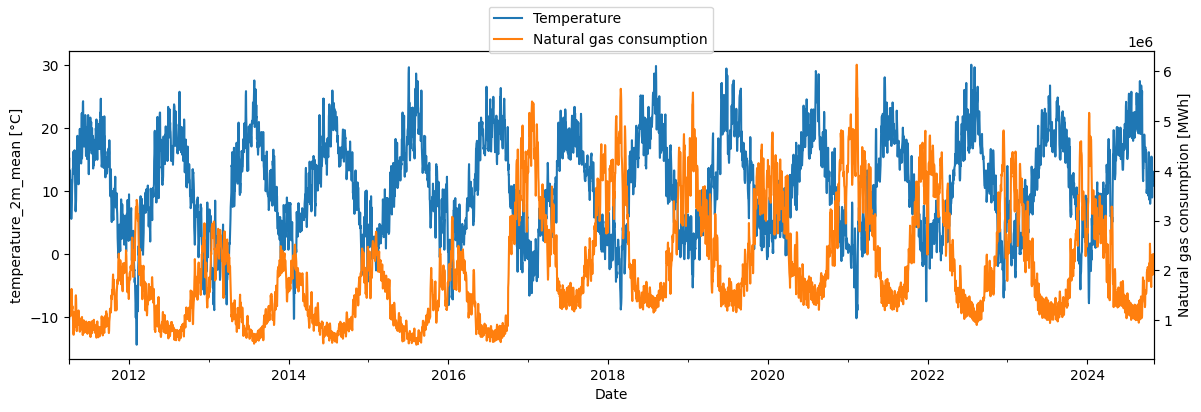

In [31]:
import os

fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temperature["temperature_2m_mean (°C)"].loc[start_date:end_date].plot(ax=ax1, color="tab:blue")
consumption_data.plot(ax=ax2, color="tab:orange")

# Labels and legend
ax1.set_ylabel("temperature_2m_mean [°C]")
ax2.set_ylabel("Natural gas consumption [MWh]")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "Natural gas consumption"],

    loc="upper center",
)

# Create directory if it does not exist
os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/data_analysis_003_001.svg", format="svg", bbox_inches="tight")